In [1]:
#pip install pandas-profiling

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#pd.set_option('display.max_rows', None)  # or 1000

In [4]:
#Import Packages
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import networkx as nx
from urllib import parse
from scipy import stats
from functools import reduce
from pandas_profiling import ProfileReport
import numpy as np
import scipy.sparse
import scipy.sparse.csgraph

# 1 DB connection and getting the data

In [5]:
### Get the general information from database into a df

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("/Users/Michael/The Data City/The Data City - Documents/Product/Backups/ClassifiedCompaniesRelational_May2021_LEPfix.db")
df_tdc_general = pd.read_sql_query("SELECT CompanyNumber, Homepage_domain, RegisteredPostcode from ClassifiedCompaniesRelational", con)

# Verify that result of SQL query is stored in the dataframe
print(df_tdc_general.head())

con.close()

  CompanyNumber          Homepage_domain RegisteredPostcode
0      00000086          kentstone.co.uk           TN25 6SX
1      00000118        hobbsparker.co.uk           TN23 1DA
2      00000121                                    EC4A 2EA
3      00000133         theshipslist.com           SW1E 5JQ
4      00000140  nctilesandbathrooms.com            RM8 1SP


In [57]:
df_tdc_general['CompanyNumber'].to_csv('companynumbers.csv', index=False)

In [6]:
### Get the SIC information from database into a df

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("/Users/Michael/The Data City/The Data City - Documents/Product/Backups/ClassifiedCompaniesRelational_May2021_LEPfix.db")
df_tdc_sic = pd.read_sql_query("SELECT CompanyNumber, SIC from CompanySIC", con)

# Verify that result of SQL query is stored in the dataframe
print(df_tdc_sic.head())

con.close()

  CompanyNumber    SIC
0      00000086  68209
1      00000118  46110
2      00000121  70100
3      00000133  50200
4      00000140  46730


In [7]:
### Get the SICHLU information from database into a df

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("/Users/Michael/The Data City/The Data City - Documents/Product/Backups/ClassifiedCompaniesRelational_May2021_LEPfix.db")
df_tdc_sichlu = pd.read_sql_query("SELECT CompanyNumber, SICHLU from CompanySICHLU", con)

# Verify that result of SQL query is stored in the dataframe
print(df_tdc_sichlu.head())

con.close()

  CompanyNumber SICHLU
0      00000086      L
1      00000118      G
2      00000121      M
3      00000133      H
4      00000140      G


# 2 Prepare all dataframes to be use

In [8]:
# Combine the three df's from step one
df_tdc_gen_sic = df_tdc_general.merge(df_tdc_sic, on='CompanyNumber', how='inner')
df_tdc_combined = df_tdc_gen_sic.merge(df_tdc_sichlu, on='CompanyNumber', how='inner')
df_tdc_combined.head()

,CompanyNumber,Homepage_domain,RegisteredPostcode,SIC,SICHLU
0,00000086,kentstone.co.uk,TN25 6SX,68209,L
1,00000118,hobbsparker.co.uk,TN23 1DA,46110,G
2,00000121,,EC4A 2EA,70100,M
3,00000133,theshipslist.com,SW1E 5JQ,50200,H
4,00000140,nctilesandbathrooms.com,RM8 1SP,46730,G


In [9]:
len(df_tdc_combined)

6422483

In [10]:
#read in the file with all in- and out-degree links
df_tdc_links = pd.read_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/domainlink.csv', low_memory=False)#read in the csv file
df_tdc_links.rename(columns={"OriginDomain": "Source", "DestinationDomain": "Target"}, 
          inplace=True)#rename columns
df_tdc_links.head(20)

,Source,Target
0,salonspy.co.uk,zenoti.com
1,salonspy.co.uk,phorest.com
2,salonspy.co.uk,b2bscheduleit.com
3,salonspy.co.uk,salonadvantage.net
4,salonspy.co.uk,saloniris.co.uk
5,salonspy.co.uk,premiersoftware.uk
6,salonspy.co.uk,saloniq.com
7,salonspy.co.uk,shortcuts.co.uk
8,salonspy.co.uk,isalonsoftware.co.uk
9,salonspy.co.uk,wella.com


As we see in the first twenty rows, some of the domains in "Target" will be social media channels and other not desired results. Therefore, We will delete such "Targets" after calculating all metrices.

Why not now? We are interested in the overall network of the UK economy. If many companies link to Facebook or NHS - that is fine and important to integrate in any calculation.

In [56]:
df_tdc_links['Target'].nunique()

2582467

# 3 Quick EDA of the combined dataframe. Do we have to clean something in advance?

In [11]:
#prof = ProfileReport(df_tdc_combined)
#prof

# 4 Calculate centrality measures on Link DF

In [17]:
%%time
#create a networkx graph to calculate the number of nodes and edges.
G=nx.from_pandas_edgelist(df_tdc_links, 'Source', 'Target', create_using=nx.DiGraph)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 2608225
Number of edges: 7849234
Average in degree:   3.0094
Average out degree:   3.0094
CPU times: user 53.1 s, sys: 44.3 s, total: 1min 37s
Wall time: 2min 3s


In [18]:
%%time
indegree_centrality = nx.in_degree_centrality(G)

CPU times: user 2.37 s, sys: 751 ms, total: 3.12 s
Wall time: 3.58 s


In [19]:
%%time
outdegree_centrality = nx.out_degree_centrality(G)

CPU times: user 2.89 s, sys: 2.41 s, total: 5.3 s
Wall time: 6.08 s


In [20]:
%time
eigenvector_centrality = nx.eigenvector_centrality(G)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs


In [21]:
%time
pagerank = nx.pagerank(G, alpha=0.85) #calculating pagerank

CPU times: user 6 µs, sys: 8 µs, total: 14 µs
Wall time: 32.9 µs


In [22]:
%%time
#create a dataframe out of the pagerank list
df_metrices = pd.DataFrame([pagerank, indegree_centrality, outdegree_centrality, eigenvector_centrality])
df_metrices = df_metrices.T #transpose the dataframe
df_metrices.reset_index(inplace=True) #reset the index
df_metrices.columns = ['Target', 'pagerank', 'indegree_centrality',
                       'outdegree_centrality', 'eigenvector_centrality'] #rename the columns
df_metrices.sort_values(by=['pagerank'], ascending=False) #sort the df on pagerank
df_metrices.head(5)

CPU times: user 3min 23s, sys: 3min 45s, total: 7min 9s
Wall time: 9min 17s


,Target,pagerank,indegree_centrality,outdegree_centrality,eigenvector_centrality
0,salonspy.co.uk,1.582891e-06,1.341909e-05,0.000018,7.891143e-07
1,zenoti.com,3.356687e-07,7.668053e-07,0.000000,1.928796e-07
2,phorest.com,1.273950e-05,1.115702e-04,0.000012,1.123007e-05
3,b2bscheduleit.com,3.281481e-07,7.668053e-07,0.000005,1.606330e-07
4,salonadvantage.net,3.030795e-07,3.834027e-07,0.000000,1.262813e-07


In [23]:
len(df_metrices)

2608225

Let's check if pagerank and indegree centrality are actually different

In [24]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

#prepare the data
x = df_metrices['pagerank']
y = df_metrices['indegree_centrality']


# calculate Pearson's correlation
corr, _ = pearsonr(x, y)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.992


In [25]:

# Example of the Pearson's Correlation test
from scipy.stats import pearsonr
x = df_metrices['pagerank']
y = df_metrices['indegree_centrality']
stat, p = pearsonr(x, y)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.992, p=0.000
Probably dependent


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff7ec9dc8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff7ec9dcf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff7ec9dc550>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff7ec9db670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff7ec9db970>],
 'means': []}

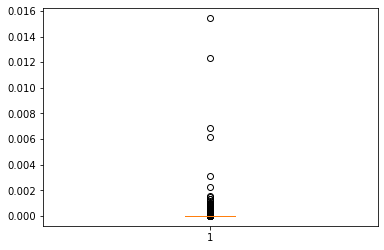

In [31]:
plt.boxplot(df_metrices['pagerank'])#visualize indegree distribution

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff7c3e2ddf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff7c3e0b4f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff7c3e2da90>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff7c3e0bbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff7c3e0bee0>],
 'means': []}

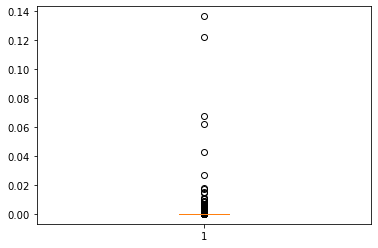

In [32]:
plt.boxplot(df_metrices['indegree_centrality'])#visualize indegree distribution

In [34]:
df_metrices['indegree_centrality'].nunique()

922

In [35]:
df_metrices['pagerank'].nunique()

274787

In [36]:
len(df_metrices)
2 608 225
274 787

2608225

# 5 Merge the df with centrality measures and the TDC data set

In [37]:
df_tdc_links['Target'] = df_tdc_links['Target'].astype('string')
df_tdc_links['Source'] = df_tdc_links['Source'].astype('string')

df_tdc_combined['Homepage_domain'] = df_tdc_combined['Homepage_domain'].astype('string')
df_tdc_combined['CompanyNumber'] = df_tdc_combined['CompanyNumber'].astype('string')
df_tdc_combined['RegisteredPostcode'] = df_tdc_combined['RegisteredPostcode'].astype('string')
df_tdc_combined['SIC'] = df_tdc_combined['SIC'].astype('category')
df_tdc_combined['SICHLU'] = df_tdc_combined['SICHLU'].astype('category')

df_metrices['Target'] = df_metrices['Target'].astype('string')

In [38]:
###merge links with the other one
df_links_tdc_comb = df_tdc_combined.merge(df_tdc_links, left_on='Homepage_domain', right_on='Target', how='inner')

#merge with metrices
df_links_tdc_comb = df_links_tdc_comb.merge(df_metrices, on='Target', how='right')

len(df_links_tdc_comb)

23980840

In [39]:
df_links_tdc_comb['CompanyNumber'].nunique()

902781

As we can see, the df has a total length of 23.9mln rows, whereas the unique Company Numbers equate only to a length of 902'781 rows. If looking into an example of a company number appearing several times, one will see that the same company number may have various SIC and SICHLU codes. As we cannot evaluate and judge which single SIC(HLU) they should be counted in, I have to consider whether deleting all companies with multiple occurences is an option.

In [ ]:
counts=df_links_tdc_comb['CompanyNumber'].value_counts()

In [ ]:
counts.head()

There are 411532 values which occure only once. Let's see how many companies we can get per SICHLU

In [ ]:
df_links_tdc_comb['SICHLU'].value_counts()

Only six categories have below 10'000 unique companies. As the training set generation will ultimately have to focus on the distribution across all categories with a respective weighting, this appears to be not an important problem and we can go ahead.

Before, we go ahead with the training set, we have to delete duplicate domains. It might be that a company has several company numbers and several  businesses but the same domain.

In [51]:
df_links_tdc_comb = df_links_tdc_comb.drop_duplicates(subset=['Homepage_domain'])

In [53]:
#toplist=df_links_tdc_comb.sort_values(by='pagerank', ascending=False)
toplist.head(10)

,CompanyNumber,Homepage_domain,RegisteredPostcode,SIC,SICHLU,Source,Target,pagerank,indegree_centrality,outdegree_centrality,eigenvector_centrality
22015003,<NA>,<NA>,<NA>,NaN,NaN,<NA>,facebook.com,0.015433,0.136689,0.000007,0.444616
21309524,09356191,twitter.com,W1B 5AN,62012,J,globalvanlines.com,twitter.com,0.012366,0.122649,0.000009,0.483314
15268017,10195014,google.com,E16 1AH,99999,U,tmsa.scot,google.com,0.002264,0.026671,0.000084,0.183759
17559702,11210970,ico.org.uk,B16 0EF,80100,N,mentalhealth-uk.org,ico.org.uk,0.001467,0.018033,0.000014,0.112136
10353761,SC266408,google.co.uk,EH3 8BL,86220,Q,03interiors.co.uk,google.co.uk,0.001027,0.010767,0.000013,0.079179
20881082,08778322,cloudflare.com,SE1 7PB,62012,J,israuk.org,cloudflare.com,0.000515,0.004996,0.000036,0.010998
19486617,07460045,godaddy.com,IP11 2LN,82990,N,flyexair.com,godaddy.com,0.000354,0.001287,0.000049,0.000045
18213105,07479536,ionos.co.uk,DL6 2XQ,01110,A,specialcareservices.co.uk,ionos.co.uk,0.000338,0.002176,0.000026,0.000103
20491141,07600360,pinterest.co.uk,IP2 0AJ,41202,F,williamhunt.co.uk,pinterest.co.uk,0.000329,0.003977,0.000001,0.006892
11659115,11049023,adobe.com,PE13 4LF,99999,U,gillenterpriseslondon.com,adobe.com,0.000277,0.002496,0.000026,0.017818


In [49]:
toplist['Homepage_domain']=toplist['Homepage_domain'].astype(str)

In [50]:
toplist=toplist.drop_duplicates(subset=['Homepage_domain'])

# 6 Delete the "Target" rows containing domains not interesting for our analysis.

In [ ]:
#Therefore, let's get rid of companies which should not be considered.
delete = ['.org', 'gov.uk', 'ac.uk', 'twitter', 'facebook', 'instagram',
          'youtu.be', 'pinterest', 'amazon', 'google', 'cloudflare', 'godaddy',
         'tumbler', 'reddit', 'wix', 'soundcloud', 'flickr', ] #dict what to delete

#delete the rows we do not consider necessary
df_links_tdc_comb = df_links_tdc_comb[~df_links_tdc_comb.Target.str.contains('|'.join(delete), na=False)]

len(df_links_tdc_comb) #the number of rows post changes. We saved some 60'000 nodes!

# 7 Exploration of the final df

In [ ]:
#let's count how frequent some values reappear
eda=df_links_tdc_comb['pagerank'].value_counts()
eda.head(100) #Can we set a cut off rate?

In [ ]:
len(eda)

In [ ]:
#plt.figure(figsize=(8, 6))
#plt.hist(df_links_tdc_comb['SIC'])

In [ ]:
df_links_tdc_comb['SIC'].value_counts()

In [ ]:
#plt.hist(df_links_tdc_comb['SICHLU'])

While most SICHLU groups have more than 40,000 companies, TEP have significantly less. Besides these three groups, I do not expect any troubles in generating a training set.

In [ ]:
df_links_tdc_comb['SICHLU'].value_counts()

This showed us that SIC are not feasible as too many codes have too little for any proper training set. Therefore, SICHLU will be used. 

In [ ]:
df_links_tdc_comb.head()

In [ ]:
#save the final dataframe as csv
df_links_tdc_comb.to_csv('/Users/Michael/Library/Mobile Documents/com~apple~CloudDocs/Universität/UCL/Programming/MasterThesis/Data/df_links_tdc_comb.csv', index=False)

